In [4]:
# Importing necessary libraries
!pip install torchmetrics
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, random_split , Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import BinaryAccuracy
from PIL import Image
from sklearn.model_selection import train_test_split
from collections import Counter
import pandas as pd


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics
from sklearn.metrics import confusion_matrix

# Suppressing warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [8]:
# Define the path to the dataset
# The path '/kaggle/input/ai-generated-images-vs-real-images' is specific to Kaggle environments.
# In Google Colab, you need to provide a valid path to your dataset.
# Options:
# 1. Upload your dataset directly to Colab's file system.
# 2. Mount Google Drive and specify the path there.
#    e.g., from google.colab import drive; drive.mount('/content/drive'); path = '/content/drive/My Drive/YourDatasetFolder'
# 3. If using a pre-downloaded dataset in Colab's temporary storage, specify its path.

# Please update the 'path' variable below with the correct location of your dataset.
path = 'YOUR_DATASET_PATH_HERE'

In [10]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import kagglehub

# Download latest version
path = kagglehub.dataset_download("cashbowman/ai-generated-images-vs-real-images")

print("Path to dataset files:", path)
# Define the path to your dataset

img_size = 28
transform = transforms.Compose([
    transforms.Resize((img_size,img_size)),  # Resize the images to a fixed size
    transforms.ToTensor()  # Convert images to PyTorch tensors
])
# Load the dataset
data = datasets.ImageFolder(root=path, transform=transform)

# # Define batch size
batch_size = 32

# # Create DataLoader
data_loader = DataLoader(data, batch_size=batch_size, shuffle=True)

# # Iterate through the DataLoader
#for batch_images, batch_labels in data_loader:
#     print the shape of the batch of images
  #  print("Batch images shape:", batch_images.shape)
     # Print the shape of the batch of labels
  #  print("Batch labels shape:", batch_labels.shape)

Using Colab cache for faster access to the 'ai-generated-images-vs-real-images' dataset.
Path to dataset files: /kaggle/input/ai-generated-images-vs-real-images


In [11]:
# Create an ImageFolder object
data = datasets.ImageFolder(root=path)

# Extract labels from the dataset
images, labels = zip(*data.samples)

# Count the occurrences of each label
label_counts = Counter(labels)

# Print the label counts
print("Label Counts:")
for label, count in label_counts.items():
    print(f"Label {label}: {count} samples")

Label Counts:
Label 0: 539 samples
Label 1: 434 samples


Tensor image shape: torch.Size([3, 256, 256])


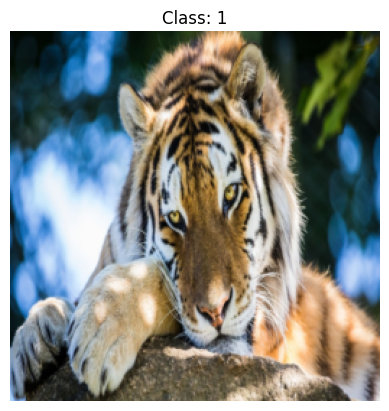

In [12]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# Define path to your image folder
path = path
img_size = 256

# Define transformations to apply to the images
transform = transforms.Compose([
    transforms.Resize((img_size,img_size)),  # Resize the images to a fixed size
    transforms.ToTensor()  # Convert images to PyTorch tensors
])

# Create an ImageFolder object
data = datasets.ImageFolder(root=path, transform=transform)

# Select an image index to display
image_index = 709

# Access an image and its corresponding label
image, label = data[image_index]

# Print the shape of the tensor image
print("Tensor image shape:", image.shape)

# Convert the tensor image to a PIL image
image_pil = transforms.ToPILImage()(image)

# Display the image along with its label
plt.imshow(image_pil)
plt.title(f"Class: {label}")
plt.axis('off')
plt.show()

In [13]:
# Create an ImageFolder object
data = datasets.ImageFolder(root=path) # , transform=transform

# Extract labels from the dataset
images, labels = zip(*data.samples)

# Perform stratified splitting
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, stratify=labels)

In [14]:
# Zip train images with train labels and create DataFrame
train_data_df = pd.DataFrame({'images': train_images, 'labels': train_labels})

# Zip test images with test labels and create DataFrame
test_data_df = pd.DataFrame({'images': test_images, 'labels': test_labels})


class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]
        image = Image.open(img_name)

        # Convert image to tensor
        image = self.transform(image)

        # Ensure image has three channels (RGB)
        if image.shape[0] == 1:  # If grayscale, convert to RGB
            image = image.expand(3, -1, -1)  # Expand grayscale to three channels
        elif image.shape[0] == 4:  # If RGBA, remove alpha channel
            image = image[:3]  # Remove alpha channel

        label = self.dataframe.iloc[idx, 1]

        return image, label

In [15]:
img_size = 100

# Assuming transform is defined elsewhere
train_transform = transforms.Compose([
    transforms.Resize((img_size,img_size)),
#     transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

test_transform = transforms.Compose([
    transforms.Resize((img_size,img_size)),
#     transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

# Create custom datasets for train and test sets
train_dataset = CustomImageDataset(train_data_df, transform=train_transform)
test_dataset = CustomImageDataset(test_data_df, transform=test_transform)


Train Dataset:
Sample 1  - Image shape: torch.Size([3, 100, 100])  - Label: 1
Sample 2  - Image shape: torch.Size([3, 100, 100])  - Label: 1
Sample 3  - Image shape: torch.Size([3, 100, 100])  - Label: 0
Sample 4  - Image shape: torch.Size([3, 100, 100])  - Label: 0
Sample 5  - Image shape: torch.Size([3, 100, 100])  - Label: 1

Test Dataset:
Sample 1  - Image shape: torch.Size([3, 100, 100])  - Label: 0
Sample 2  - Image shape: torch.Size([3, 100, 100])  - Label: 1
Sample 3  - Image shape: torch.Size([3, 100, 100])  - Label: 1
Sample 4  - Image shape: torch.Size([3, 100, 100])  - Label: 1
Sample 5  - Image shape: torch.Size([3, 100, 100])  - Label: 0


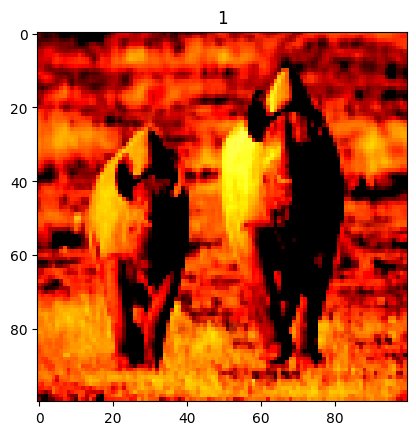

In [16]:
train_dataset[0][0].shape , train_dataset[0][1]

plt.imshow(train_dataset[4][0].permute(1,2,0))
plt.title(train_dataset[0][1])

print("Train Dataset:")
for i in range(5):  # Print the first 5 samples
    sample = train_dataset[i]
    print("Sample", i+1, " - Image shape:", sample[0].shape, " - Label:", sample[1])

# Print samples from test dataset
print("\nTest Dataset:")
for i in range(5):  # Print the first 5 samples
    sample = test_dataset[i]
    print("Sample", i+1, " - Image shape:", sample[0].shape, " - Label:", sample[1])

In [18]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [19]:
num_train_batches = len(train_loader)

# Calculate the number of batches in test_loader
num_test_batches = len(test_loader)

# Print the counts
print("Number of batches in train_loader:", num_train_batches)
print("Number of batches in test_loader:", num_test_batches)

Number of batches in train_loader: 25
Number of batches in test_loader: 7


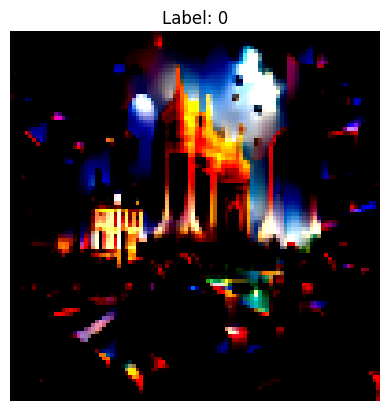

In [20]:
i, f = next(iter(train_loader))

# Extracting the first image from the batch
image = i[0]
label = f[0]

# Plotting the image
plt.imshow(image.permute(1, 2, 0))  # Permute to (H, W, C) for displaying with matplotlib
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

In [21]:
for batch_idx, (images, labels) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}: {images.shape}")

Batch 1: torch.Size([32, 3, 100, 100])
Batch 2: torch.Size([32, 3, 100, 100])
Batch 3: torch.Size([32, 3, 100, 100])
Batch 4: torch.Size([32, 3, 100, 100])
Batch 5: torch.Size([32, 3, 100, 100])
Batch 6: torch.Size([32, 3, 100, 100])
Batch 7: torch.Size([32, 3, 100, 100])
Batch 8: torch.Size([32, 3, 100, 100])
Batch 9: torch.Size([32, 3, 100, 100])
Batch 10: torch.Size([32, 3, 100, 100])
Batch 11: torch.Size([32, 3, 100, 100])
Batch 12: torch.Size([32, 3, 100, 100])
Batch 13: torch.Size([32, 3, 100, 100])
Batch 14: torch.Size([32, 3, 100, 100])
Batch 15: torch.Size([32, 3, 100, 100])
Batch 16: torch.Size([32, 3, 100, 100])
Batch 17: torch.Size([32, 3, 100, 100])
Batch 18: torch.Size([32, 3, 100, 100])
Batch 19: torch.Size([32, 3, 100, 100])
Batch 20: torch.Size([32, 3, 100, 100])
Batch 21: torch.Size([32, 3, 100, 100])
Batch 22: torch.Size([32, 3, 100, 100])
Batch 23: torch.Size([32, 3, 100, 100])
Batch 24: torch.Size([32, 3, 100, 100])
Batch 25: torch.Size([10, 3, 100, 100])


In [22]:
for batch_idx, (images, labels) in enumerate(test_loader):
    print(f"Batch {batch_idx + 1}: {images.shape}")

Batch 1: torch.Size([32, 3, 100, 100])
Batch 2: torch.Size([32, 3, 100, 100])
Batch 3: torch.Size([32, 3, 100, 100])
Batch 4: torch.Size([32, 3, 100, 100])
Batch 5: torch.Size([32, 3, 100, 100])
Batch 6: torch.Size([32, 3, 100, 100])
Batch 7: torch.Size([3, 3, 100, 100])


In [23]:
# Using a pre-trained EfficientNetV2L model
model = models.efficientnet_b7(weights = 'DEFAULT')

Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth


100%|██████████| 255M/255M [00:01<00:00, 161MB/s]


In [24]:
!pip install torchinfo -q
from torchinfo import summary
# We visualize our neural network before freezing the extractor layers..
summary(model, input_size = [1,3,112,112],
        col_names = ["input_size", "output_size", "num_params", "trainable"],
       col_width = 18,
       row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape        Output Shape       Param #            Trainable
EfficientNet (EfficientNet)                                  [1, 3, 112, 112]   [1, 1000]          --                 True
├─Sequential (features)                                      [1, 3, 112, 112]   [1, 2560, 4, 4]    --                 True
│    └─Conv2dNormActivation (0)                              [1, 3, 112, 112]   [1, 64, 56, 56]    --                 True
│    │    └─Conv2d (0)                                       [1, 3, 112, 112]   [1, 64, 56, 56]    1,728              True
│    │    └─BatchNorm2d (1)                                  [1, 64, 56, 56]    [1, 64, 56, 56]    128                True
│    │    └─SiLU (2)                                         [1, 64, 56, 56]    [1, 64, 56, 56]    --                 --
│    └─Sequential (1)                                        [1, 64, 56, 56]    [1, 32, 56, 56]    --                 True
│    │    └─M

In [25]:
# Modifying final classifier layer
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)

In [26]:
summary(model, input_size = [1,3,112,112],
        col_names = ["input_size", "output_size", "num_params", "trainable"],
       col_width = 18,
       row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape        Output Shape       Param #            Trainable
EfficientNet (EfficientNet)                                  [1, 3, 112, 112]   [1, 1]             --                 True
├─Sequential (features)                                      [1, 3, 112, 112]   [1, 2560, 4, 4]    --                 True
│    └─Conv2dNormActivation (0)                              [1, 3, 112, 112]   [1, 64, 56, 56]    --                 True
│    │    └─Conv2d (0)                                       [1, 3, 112, 112]   [1, 64, 56, 56]    1,728              True
│    │    └─BatchNorm2d (1)                                  [1, 64, 56, 56]    [1, 64, 56, 56]    128                True
│    │    └─SiLU (2)                                         [1, 64, 56, 56]    [1, 64, 56, 56]    --                 --
│    └─Sequential (1)                                        [1, 64, 56, 56]    [1, 32, 56, 56]    --                 True
│    │    └─M

In [27]:
criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [28]:
import copy

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.best_accuracy = None  # New attribute to track best accuracy
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss, val_accuracy):
        if self.best_loss is None or val_loss < self.best_loss:  # Update if val_loss is better
            self.best_loss = val_loss
            self.best_accuracy = val_accuracy  # Update best accuracy along with best loss
            self.best_model = copy.deepcopy(model.state_dict())
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}. " \
                          # f"Best Loss: {self.best_loss:.4f}, Best Accuracy: {self.best_accuracy:.2f}%"

        elif self.best_loss - val_loss >= self.min_delta:
            self.best_model = copy.deepcopy(model.state_dict())
            self.best_loss = val_loss
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}. " \
                          # f"Best Loss: {self.best_loss:.4f}, Best Accuracy: {self.best_accuracy:.2f}%"

        else:
            self.counter += 1
            self.status = f"No improvement in the last {self.counter} epochs. " \
                          # f"Best Loss: {self.best_loss:.4f}, Best Accuracy: {self.best_accuracy:.2f}%"
            if self.counter >= self.patience:
                self.status = f"Early stopping triggered after {self.counter} epochs. " \
                              f"Best Loss: {self.best_loss:.4f}, Best Accuracy: {self.best_accuracy:.2f}%"
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
        return False


In [29]:
# Define EarlyStopping
early_stopping = EarlyStopping(patience = 10, min_delta = 0.0)


In [30]:
from tqdm.autonotebook import tqdm
def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer):

    model.train()

    train_loss = 0.
    accuracy_train = BinaryAccuracy(threshold = 0.5).to(device)

    for batch,(X,y) in enumerate(tqdm(dataloader)):
        X,y = X.to(device,dtype=torch.float32), y.to(device,dtype=torch.float32)

        y_pred = model(X).squeeze()
        loss = loss_fn(y_pred, y)
        train_loss += loss.detach().cpu().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_proba = torch.sigmoid(y_pred)
        accuracy_train.update(y_proba, y)

    train_accuracy = accuracy_train.compute()
    train_loss = train_loss/len(dataloader)


    return train_loss, train_accuracy

In [31]:
def test_step(model:torch.nn.Module,
              dataloader:torch.utils.data.DataLoader,
              loss_fn:torch.nn.Module):

    model.eval()

    test_loss = 0.
    accuracy_test = BinaryAccuracy(threshold = 0.5).to(device)

    for batch,(X,y) in enumerate(tqdm(dataloader)):
        X,y = X.to(device,dtype=torch.float32), y.to(device,dtype=torch.float32)

        y_pred = model(X).squeeze()

        loss = loss_fn(y_pred, y)
        test_loss += loss.detach().cpu().item()

        y_proba = torch.sigmoid(y_pred)
        accuracy_test.update(y_proba, y)

    test_accuracy = accuracy_test.compute()
    test_loss = test_loss/len(dataloader)

    return test_loss, test_accuracy

In [32]:
def train(model:torch.nn.Module,
          train_dataloader:torch.utils.data.DataLoader,
          test_dataloader:torch.utils.data.DataLoader,
          loss_fn:torch.nn.Module,
          optimzier:torch.optim.Optimizer,
          epochs:int):

    best_test_loss = float('inf')

    results = {'train_loss':[],
               'train_accuracy':[],
               'test_loss':[],
               'test_accuracy':[]}

    for epoch in tqdm(range(epochs)):
        train_loss, train_accuracy = train_step(model = model,
                                                dataloader = train_dataloader,
                                                loss_fn = loss_fn,
                                                optimizer = optimizer)

        test_loss, test_accuracy = test_step(model = model,
                                             dataloader = test_dataloader,
                                             loss_fn = loss_fn)



        print(f"Epoch: {epoch+1} | ",
              f"Train Loss: {train_loss:.4f} | ",
              f"Train Accuracy: {train_accuracy:.4f} | ",
              f"Test Loss: {test_loss:.4f} | ",
              f"Test Accuracy: {test_accuracy:.4f}")


        print(early_stopping.status)
        if early_stopping(model,test_loss,test_accuracy):
            print(early_stopping.status)
            print("Early Stopping!!")
            break

        results["train_loss"].append(train_loss)
        results["train_accuracy"].append(train_accuracy.detach().cpu().item())
        results["test_loss"].append(test_loss)
        results["test_accuracy"].append(test_accuracy.detach().cpu().item())

    return results

In [33]:
def train(model:torch.nn.Module,
          train_dataloader:torch.utils.data.DataLoader,
          test_dataloader:torch.utils.data.DataLoader,
          loss_fn:torch.nn.Module,
          optimzier:torch.optim.Optimizer,
          epochs:int):

    best_test_loss = float('inf')

    results = {'train_loss':[],
               'train_accuracy':[],
               'test_loss':[],
               'test_accuracy':[]}

    for epoch in tqdm(range(epochs)):
        train_loss, train_accuracy = train_step(model = model,
                                                dataloader = train_dataloader,
                                                loss_fn = loss_fn,
                                                optimizer = optimizer)

        test_loss, test_accuracy = test_step(model = model,
                                             dataloader = test_dataloader,
                                             loss_fn = loss_fn)



        print(f"Epoch: {epoch+1} | ",
              f"Train Loss: {train_loss:.4f} | ",
              f"Train Accuracy: {train_accuracy:.4f} | ",
              f"Test Loss: {test_loss:.4f} | ",
              f"Test Accuracy: {test_accuracy:.4f}")


        print(early_stopping.status)
        if early_stopping(model,test_loss,test_accuracy):
            print(early_stopping.status)
            print("Early Stopping!!")
            break

        results["train_loss"].append(train_loss)
        results["train_accuracy"].append(train_accuracy.detach().cpu().item())
        results["test_loss"].append(test_loss)
        results["test_accuracy"].append(test_accuracy.detach().cpu().item())

    return results

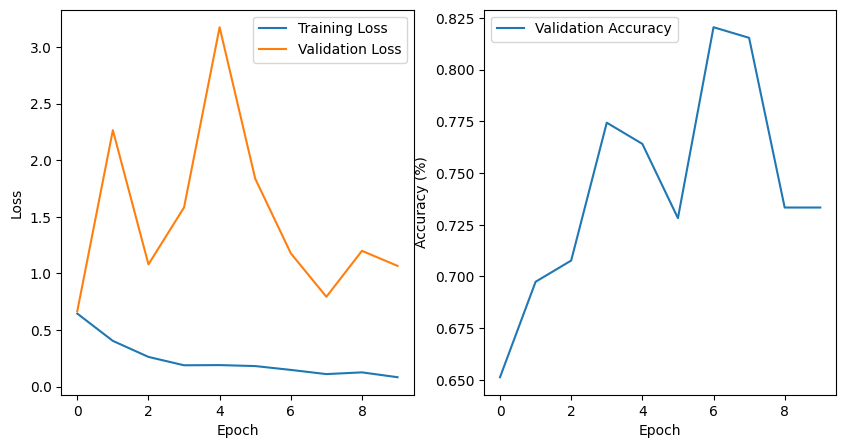

In [36]:
# Plotting training and validation metrics
plt.figure(figsize = (10, 5))

plt.subplot(1, 2, 1)
plt.plot(MODEL_RESULTS["train_loss"], label = 'Training Loss')
plt.plot(MODEL_RESULTS["test_loss"], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(MODEL_RESULTS["test_accuracy"], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

In [35]:
model.to(device)
MODEL_RESULTS = train(model = model,
                      train_dataloader = train_loader,
                      test_dataloader = test_loader,
                      loss_fn = criterion,
                      optimzier = optimizer,
                      epochs = 20)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1 |  Train Loss: 0.6455 |  Train Accuracy: 0.6825 |  Test Loss: 0.6670 |  Test Accuracy: 0.6513



  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 2 |  Train Loss: 0.4042 |  Train Accuracy: 0.8355 |  Test Loss: 2.2658 |  Test Accuracy: 0.6974
Improvement found, counter reset to 0. 


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 3 |  Train Loss: 0.2627 |  Train Accuracy: 0.8972 |  Test Loss: 1.0804 |  Test Accuracy: 0.7077
No improvement in the last 1 epochs. 


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 4 |  Train Loss: 0.1888 |  Train Accuracy: 0.9229 |  Test Loss: 1.5831 |  Test Accuracy: 0.7744
No improvement in the last 2 epochs. 


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 5 |  Train Loss: 0.1904 |  Train Accuracy: 0.9319 |  Test Loss: 3.1756 |  Test Accuracy: 0.7641
No improvement in the last 3 epochs. 


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 6 |  Train Loss: 0.1818 |  Train Accuracy: 0.9319 |  Test Loss: 1.8382 |  Test Accuracy: 0.7282
No improvement in the last 4 epochs. 


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 7 |  Train Loss: 0.1479 |  Train Accuracy: 0.9434 |  Test Loss: 1.1786 |  Test Accuracy: 0.8205
No improvement in the last 5 epochs. 


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 8 |  Train Loss: 0.1108 |  Train Accuracy: 0.9576 |  Test Loss: 0.7939 |  Test Accuracy: 0.8154
No improvement in the last 6 epochs. 


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 9 |  Train Loss: 0.1262 |  Train Accuracy: 0.9486 |  Test Loss: 1.1998 |  Test Accuracy: 0.7333
No improvement in the last 7 epochs. 


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 10 |  Train Loss: 0.0833 |  Train Accuracy: 0.9730 |  Test Loss: 1.0670 |  Test Accuracy: 0.7333
No improvement in the last 8 epochs. 


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 11 |  Train Loss: 0.1479 |  Train Accuracy: 0.9486 |  Test Loss: 0.9988 |  Test Accuracy: 0.8000
No improvement in the last 9 epochs. 
Early stopping triggered after 10 epochs. Best Loss: 0.6670, Best Accuracy: 0.65%
Early Stopping!!


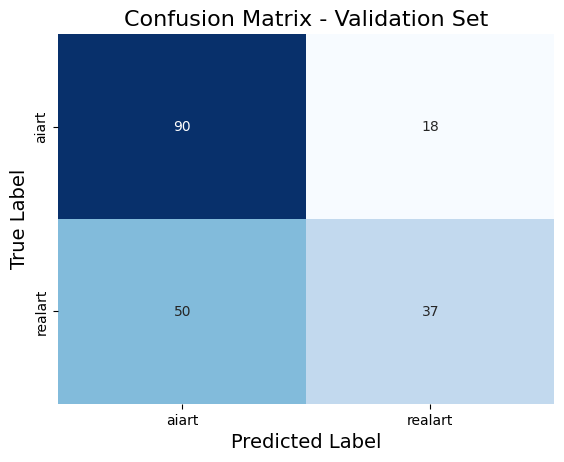

In [37]:
# Plotting confusion matrix for validation data
model.eval()
allLabels = []
allPreds = []

valLoader = test_loader
with torch.no_grad():
    for inputs, labels in valLoader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.unsqueeze(1).float()

        outputs = model(inputs)
        predictions = (torch.sigmoid(outputs) > 0.5).float()

        allLabels.extend(labels.cpu().numpy())
        allPreds.extend(predictions.cpu().numpy())

allLabels = np.array(allLabels)
allPreds = np.array(allPreds)

matrix = confusion_matrix(allLabels, allPreds)

classes = ['aiart', 'realart']  # Define your classes manually
sns.heatmap(matrix, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = classes, yticklabels = classes, cbar = False)
plt.title('Confusion Matrix - Validation Set', fontsize = 16)
plt.xlabel('Predicted Label', fontsize = 14)
plt.ylabel('True Label', fontsize = 14)
plt.show()